In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, precision_score, classification_report

import random
random.seed(78)


In [9]:
df = pd.read_pickle('df_augmented_processed.pkl')
df

,note,auteur,avis_length,maj_pourcentage,exclam_pourcentage,max_maj_in_a_row,max_exclam_in_a_row,0_word,00_word,000_word,...,produit_credit,produit_flotte-automobile,produit_garantie-decennale,produit_habitation,produit_moto,produit_multirisque-professionnelle,produit_prevoyance,produit_responsabilite-civile-professionnelle,produit_sante,produit_vie
0,4,brahim--k-131532,156.0,0.016260,0.000000,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,3,bernard-g-112497,267.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,4,virginie-t-107352,167.0,0.007299,0.000000,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,3,boulain-f-116580,155.0,0.008264,0.000000,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0,ouaille31-51798,720.0,0.009042,0.009042,1.0,3.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26002,2,data augmentation,270.0,0.034826,0.000000,2.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
26003,2,data augmentation,312.0,0.060870,0.000000,5.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
26004,2,data augmentation,154.0,0.024793,0.000000,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
26005,2,data augmentation,176.0,0.021429,0.000000,2.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [10]:
df = df.drop(['avoir_word'], axis = 1)
df = df.drop(['être_word'], axis = 1)
# train = train.drop(['exclam_pourcentage'], axis = 1)
# train = train.drop(['maj_pourcentage'], axis = 1)

We don't want to predict on the data we have augmented so we have to separate it

In [11]:
from sklearn.model_selection import train_test_split

df = df.sample(frac=1).reset_index(drop=True)
X = df[df['auteur'] != 'data augmentation'].drop(['note'],axis=1)                                        # independant features
X_augmented = df[df['auteur'] == 'data augmentation'].drop(['note'],axis=1) 
y = df[df['auteur'] != 'data augmentation']['note']					                                    # dependant variable
y_augmented = df[df['auteur'] == 'data augmentation']['note']

# Deleting the column auteur as its the one that gave us the information about the augmented data
X = X.drop(['auteur'], axis = 1)
X_augmented = X_augmented.drop(['auteur'], axis = 1)

# Choose your test size to split between training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=78)

We add the augmented data to our train dataframe

In [12]:
X_train = pd.concat([X_train, X_augmented], axis = 0)
y_train = pd.concat([y_train, y_augmented], axis = 0)

In [21]:
d_train = lgb.Dataset(X_train.to_numpy(), label=y_train) #Load in data

In [14]:
count = 0 #Used for keeping track of the iteration number
#How many runs to perform using randomly selected hyperparameters
iterations = 20
best_MSE_score = 1000
best_epoch = 50
for i in range(iterations):
    print('iteration number', count)
    count += 1 #increment count
    try:
        d_train = lgb.Dataset(X_train.to_numpy(), label=y_train) #Load in data
        params = {} #initialize parameters

        params['learning_rate'] = np.random.uniform(0.06, 0.3)
        params['boosting_type'] = np.random.choice(['gbdt', 'dart'])
        params['objective'] = 'multiclass'
        params['metric'] = 'multi_logloss'
        params['num_class']= 5 #no.of unique values in the target class not inclusive of the end value
        params['sub_feature'] = np.random.uniform(0, 1)
        params['num_leaves'] = np.random.randint(20, 300)
        params['min_data'] = np.random.randint(10, 100)
        params['max_depth'] = np.random.randint(5, 200)
        params['verbose'] = -1
        epoch = np.random.randint(20, 100)
        print(params, epoch)
        #Train using selected parameters
        clf = lgb.train(params, d_train, epoch)
        y_pred=clf.predict(X_test) #Create predictions on test set
        #argmax() method 
        y_pred = [np.argmax(line) for line in y_pred]
        MSE_score=mean_squared_error(y_pred,y_test)
        print('MSE:', MSE_score)
        if MSE_score < best_MSE_score:
            best_MSE_score = MSE_score
            best_params = params
            best_epoch = epoch
    except: #in case something goes wrong
        print('failed with')
        print(params)
print("*" * 50)
print('Minimum is: ', best_MSE_score)
print('Used params', best_params)

iteration number 0
{'learning_rate': 0.16188113180927838, 'boosting_type': 'dart', 'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': 5, 'sub_feature': 0.5358577647666083, 'num_leaves': 21, 'min_data': 18, 'max_depth': 52, 'verbose': -1} 72
MSE: 1.904037610619469
iteration number 1
{'learning_rate': 0.255098918022722, 'boosting_type': 'dart', 'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': 5, 'sub_feature': 0.2836585849518759, 'num_leaves': 60, 'min_data': 50, 'max_depth': 140, 'verbose': -1} 88
MSE: 1.8903484513274336
iteration number 2
{'learning_rate': 0.19358643429633876, 'boosting_type': 'dart', 'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': 5, 'sub_feature': 0.8973524719329592, 'num_leaves': 90, 'min_data': 19, 'max_depth': 151, 'verbose': -1} 76
MSE: 1.8636615044247788
iteration number 3
{'learning_rate': 0.23348842522975877, 'boosting_type': 'gbdt', 'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': 5, 'sub_

Let's focus on our best model :

In [33]:
best_params = {'learning_rate': 0.18946665757566322, 'boosting_type': 'dart', 'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': 5, 'sub_feature': 0.9734682142930497, 'num_leaves': 47, 'min_data': 27, 'max_depth': 84, 'verbose': -1}
best_epoch = 30

In [34]:
print(best_params, best_epoch)
#Train using selected parameters
clf = lgb.train(best_params, d_train, best_epoch)
y_pred=clf.predict(X_test) #Create predictions on test set
#argmax() method 
y_pred = [np.argmax(line) for line in y_pred]

print('Précision du meilleur modèle : ', precision_score(y_pred,y_test,average=None).mean())
print('MSE du meilleur modèle : ', mean_squared_error(y_pred,y_test))
print('RMSE du meilleur modèle : ', mean_squared_error(y_pred,y_test, squared=False))
print(classification_report([x+1 for x in y_test], [x+1 for x in y_pred]))

{'learning_rate': 0.18946665757566322, 'boosting_type': 'dart', 'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': 5, 'sub_feature': 0.9734682142930497, 'num_leaves': 47, 'min_data': 27, 'max_depth': 84, 'verbose': -1} 30
Précision du meilleur modèle :  0.3668409268402237
MSE du meilleur modèle :  1.8480365044247788
RMSE du meilleur modèle :  1.3594250639240026
              precision    recall  f1-score   support

           1       0.56      0.78      0.65      2194
           2       0.30      0.16      0.21      1095
           3       0.19      0.08      0.11      1031
           4       0.36      0.36      0.36      1453
           5       0.39      0.45      0.42      1459

    accuracy                           0.44      7232
   macro avg       0.36      0.37      0.35      7232
weighted avg       0.39      0.44      0.40      7232



[Text(0, 0.5, '1'),
 Text(0, 1.5, '2'),
 Text(0, 2.5, '3'),
 Text(0, 3.5, '4'),
 Text(0, 4.5, '5')]

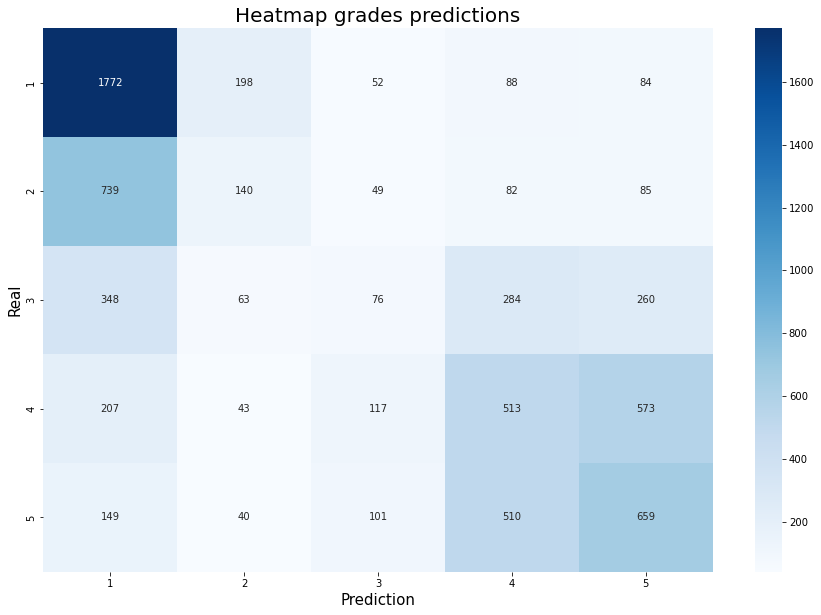

In [30]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(figsize=(15,10)) 

cm = confusion_matrix([x+1 for x in y_test], [x+1 for x in y_pred])
sns.heatmap(cm, cmap = "Blues", annot=True, fmt="d")
plt.title('Heatmap grades predictions', fontsize = 20) # title with fontsize 20
plt.xlabel('Prediction', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Real', fontsize = 15) # y-axis label with fontsize 15
ax.set_xticklabels([1,2,3,4,5])
ax.set_yticklabels([1,2,3,4,5])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

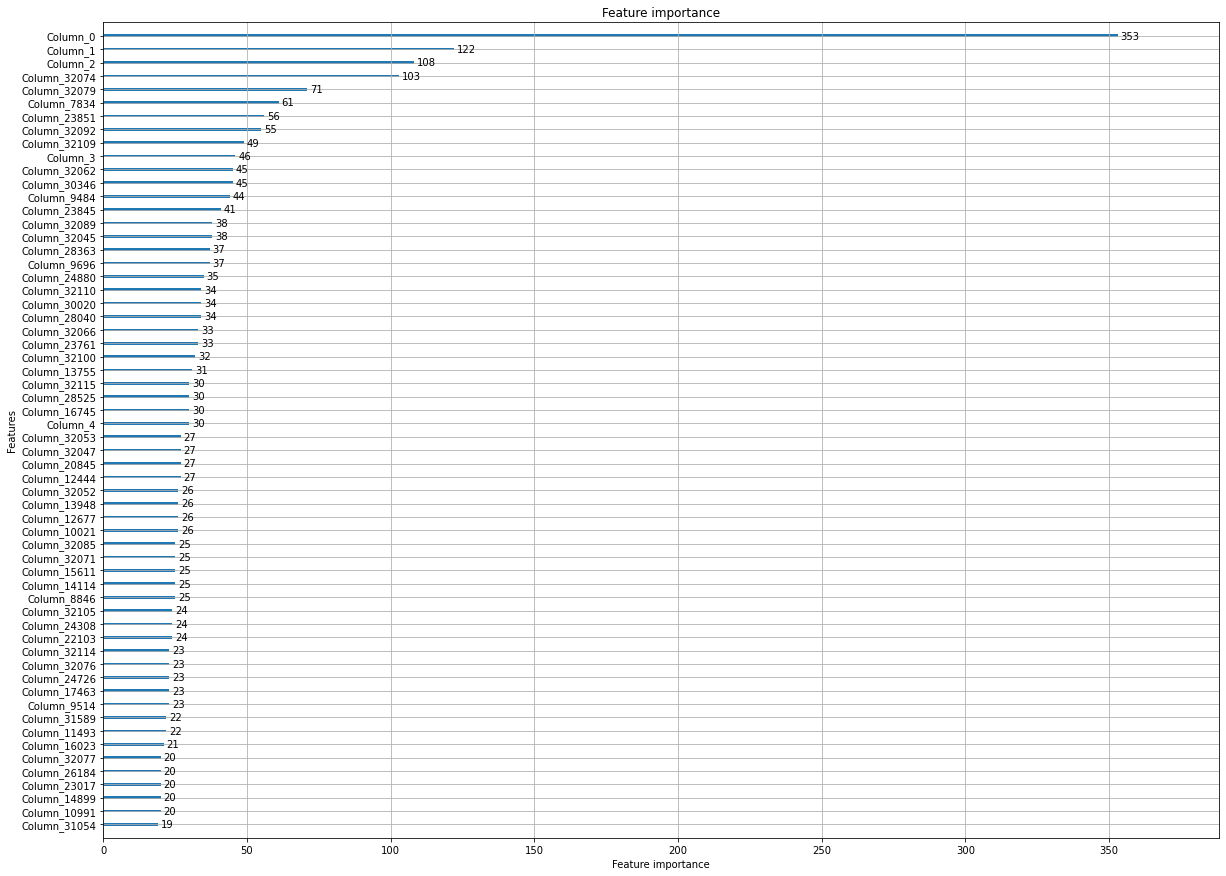

In [27]:
lgb.plot_importance(clf, max_num_features = 60, figsize=(20,15))

Version de heatmap simplifiée

[Text(0, 0.5, 'Bad'), Text(0, 1.5, 'Neutral'), Text(0, 2.5, 'Good')]

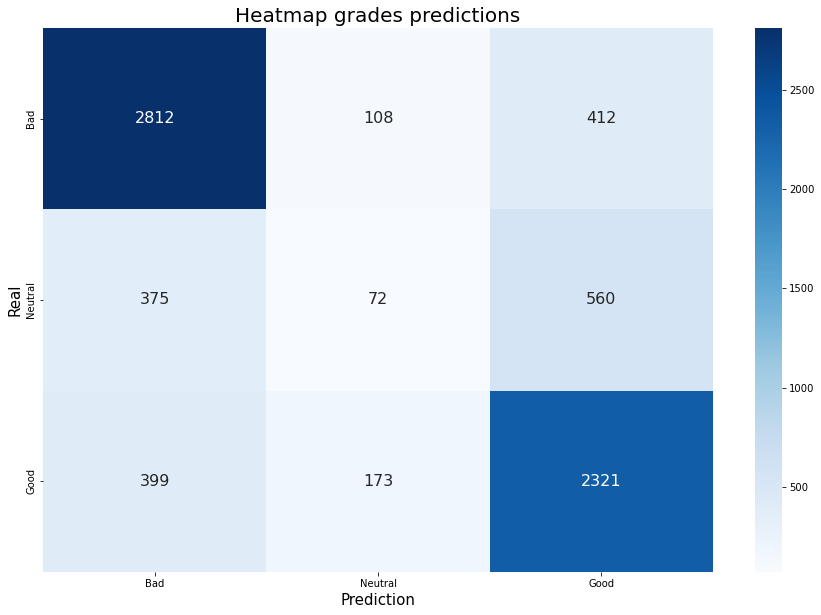

In [35]:
reduced_conf = np.array([[2812,108,412],[375,72,560],[399,173,2321]])

fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(reduced_conf, cmap = "Blues", annot=True, fmt="d", annot_kws={"size":16})
plt.title('Heatmap grades predictions', fontsize = 20) # title with fontsize 20
plt.xlabel('Prediction', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Real', fontsize = 15) # y-axis label with fontsize 15
ax.set_xticklabels(['Bad','Neutral','Good'])
ax.set_yticklabels(['Bad','Neutral','Good'])

[Text(0, 0.5, '1'),
 Text(0, 1.5, '2'),
 Text(0, 2.5, '3'),
 Text(0, 3.5, '4'),
 Text(0, 4.5, '5')]

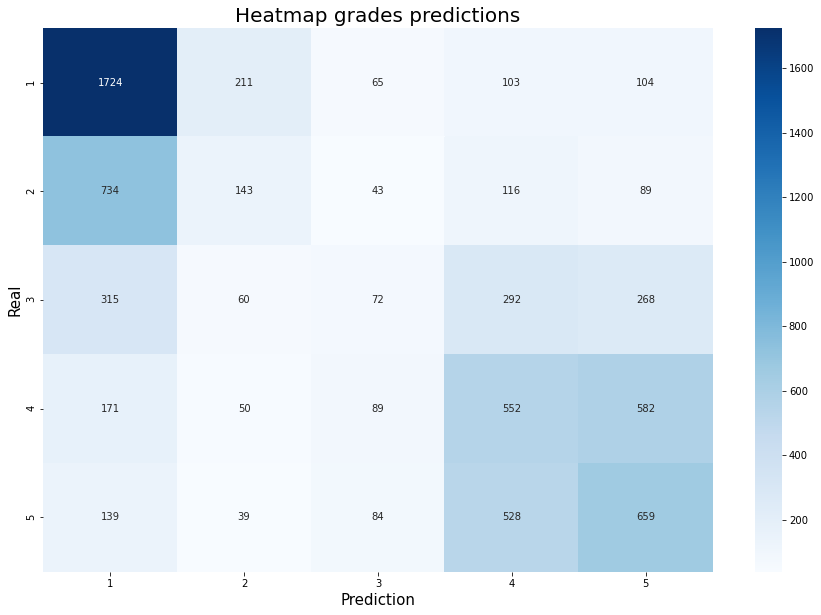

In [ ]:
best_conf = np.array([[1724,211,65,103,104],[734,143,43,116,89],[315,60,72,292,268],[171,50,89,552,582],[139,39,84,528,659]])

fig, ax = plt.subplots(figsize=(15,10)) 

sns.heatmap(best_conf, cmap = "Blues", annot=True, fmt="d")
plt.title('Heatmap grades predictions', fontsize = 20) # title with fontsize 20
plt.xlabel('Prediction', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Real', fontsize = 15) # y-axis label with fontsize 15
ax.set_xticklabels([1,2,3,4,5])
ax.set_yticklabels([1,2,3,4,5])